In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
import math
from sklearn.metrics import mean_squared_error
from pathlib import Path
from tensorflow.keras.optimizers import SGD

In [2]:
data = Path('cleaned_data.csv')
#df = pd.read_csv(data, index_col='Unnamed: 0')
df = pd.read_csv(data)
df.head()

,Unnamed: 0,CANLORSGPNOSTSAM,inflation_common,inflation_trimmed_median,inflation_weighted_median,employment_rate,unemployment_rate,participation_rate,5_year_bond_benchmark,10_year_bond_benchmark,long_term_bond_benchmark,Bank of Canada Target Overnight Rate,Mortgage Rate
0,1990-01-01,102.220629,3.4,4.9,4.7,60.4,8.7,66.1,10.045000,9.965000,9.820000,12.04,12.01
1,1990-02-01,102.203404,3.3,4.7,4.5,60.6,8.4,66.2,10.538182,10.253636,9.999091,13.00,12.42
2,1990-03-01,102.130889,3.4,4.6,4.3,60.7,8.3,66.2,11.147692,10.761538,10.596154,13.13,12.92
3,1990-04-01,101.995714,3.5,4.5,4.2,61.1,7.9,66.4,12.175000,11.519286,11.275714,13.52,13.67
4,1990-05-01,101.800030,3.6,4.3,4.0,62.4,7.8,67.6,11.741538,11.125385,10.990000,13.80,14.21


In [3]:
df = df.rename({'Unnamed: 0': 'date', 'Mortgage Rate': 'mortgage_rate'}, axis=1)
df.head()

,date,CANLORSGPNOSTSAM,inflation_common,inflation_trimmed_median,inflation_weighted_median,employment_rate,unemployment_rate,participation_rate,5_year_bond_benchmark,10_year_bond_benchmark,long_term_bond_benchmark,Bank of Canada Target Overnight Rate,mortgage_rate
0,1990-01-01,102.220629,3.4,4.9,4.7,60.4,8.7,66.1,10.045000,9.965000,9.820000,12.04,12.01
1,1990-02-01,102.203404,3.3,4.7,4.5,60.6,8.4,66.2,10.538182,10.253636,9.999091,13.00,12.42
2,1990-03-01,102.130889,3.4,4.6,4.3,60.7,8.3,66.2,11.147692,10.761538,10.596154,13.13,12.92
3,1990-04-01,101.995714,3.5,4.5,4.2,61.1,7.9,66.4,12.175000,11.519286,11.275714,13.52,13.67
4,1990-05-01,101.800030,3.6,4.3,4.0,62.4,7.8,67.6,11.741538,11.125385,10.990000,13.80,14.21


In [4]:
df.set_index('date', inplace=True)
df.head()

,CANLORSGPNOSTSAM,inflation_common,inflation_trimmed_median,inflation_weighted_median,employment_rate,unemployment_rate,participation_rate,5_year_bond_benchmark,10_year_bond_benchmark,long_term_bond_benchmark,Bank of Canada Target Overnight Rate,mortgage_rate
date,,,,,,,,,,,,
1990-01-01,102.220629,3.4,4.9,4.7,60.4,8.7,66.1,10.045000,9.965000,9.820000,12.04,12.01
1990-02-01,102.203404,3.3,4.7,4.5,60.6,8.4,66.2,10.538182,10.253636,9.999091,13.00,12.42
1990-03-01,102.130889,3.4,4.6,4.3,60.7,8.3,66.2,11.147692,10.761538,10.596154,13.13,12.92
1990-04-01,101.995714,3.5,4.5,4.2,61.1,7.9,66.4,12.175000,11.519286,11.275714,13.52,13.67
1990-05-01,101.800030,3.6,4.3,4.0,62.4,7.8,67.6,11.741538,11.125385,10.990000,13.80,14.21


In [5]:
X = df.drop(['mortgage_rate'], axis=1)
y = df['mortgage_rate']

In [240]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [241]:
window_size = 10

feature_column = 11
target_column = 11
X, y = window_data(df, window_size, feature_column, target_column)

In [242]:
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [243]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y_train)

y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test) 

In [244]:
X_train.shape[0]

250

In [245]:
X_train.shape[1]

10

In [246]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Using GRU(Gated Recurrent Units)

In [247]:
# The GRU architecture
regressorGRU = Sequential()

In [248]:
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [249]:
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [250]:
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [251]:
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [252]:
# The output layer
regressorGRU.add(Dense(units=1))

In [253]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [254]:
# Fitting to the training set
regressorGRU.fit(X_train,y_train, epochs=50, batch_size=150)

Epoch 1/50
2/2 [==============================] - 6s 29ms/step - loss: 0.1320
Epoch 2/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0728
Epoch 3/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0423
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0630
Epoch 5/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0790
Epoch 6/50
2/2 [==============================] - 0s 35ms/step - loss: 0.0600
Epoch 7/50
2/2 [==============================] - 0s 51ms/step - loss: 0.0393
Epoch 8/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0441
Epoch 9/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0514
Epoch 10/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0495
Epoch 11/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0403
Epoch 12/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0361
Epoch 13/50
2/2 [==============================] - 0s 28ms/st

In [255]:
regressorGRU.evaluate(X_test, y_test, verbose=1)

4/4 [==============================] - 1s 6ms/step - loss: 7.4549e-04


0.0007454935112036765

In [256]:
predicted = regressorGRU.predict(X_test)

In [257]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [258]:
#mortgage = pd.DataFrame({
#    "Real": real_prices.ravel(),
#    "Predicted": predicted_prices.ravel()
#}, index = df.index[-len(real_prices): ]) 
#mortgage.head()

In [259]:
#mortgage.plot(title="Real Vs. Predicted")

In [260]:
#X_test = []
#for i in range(60,311):
#    X_test.append(inputs[i-60:i,0])
#X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
#GRU_predicted_stock_price = regressorGRU.predict(X_test)
#GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [261]:
mortgage = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
mortgage.tail()

,Real,Predicted
date,,
2021-04-01,3.26,3.635887
2021-05-01,3.25,3.583284
2021-06-01,3.25,3.538765
2021-07-01,3.26,3.504451
2021-08-01,3.20,3.478016


<AxesSubplot:title={'center':'Real Mortgage rate Vs. Predicted Mortgage rate'}, xlabel='date'>

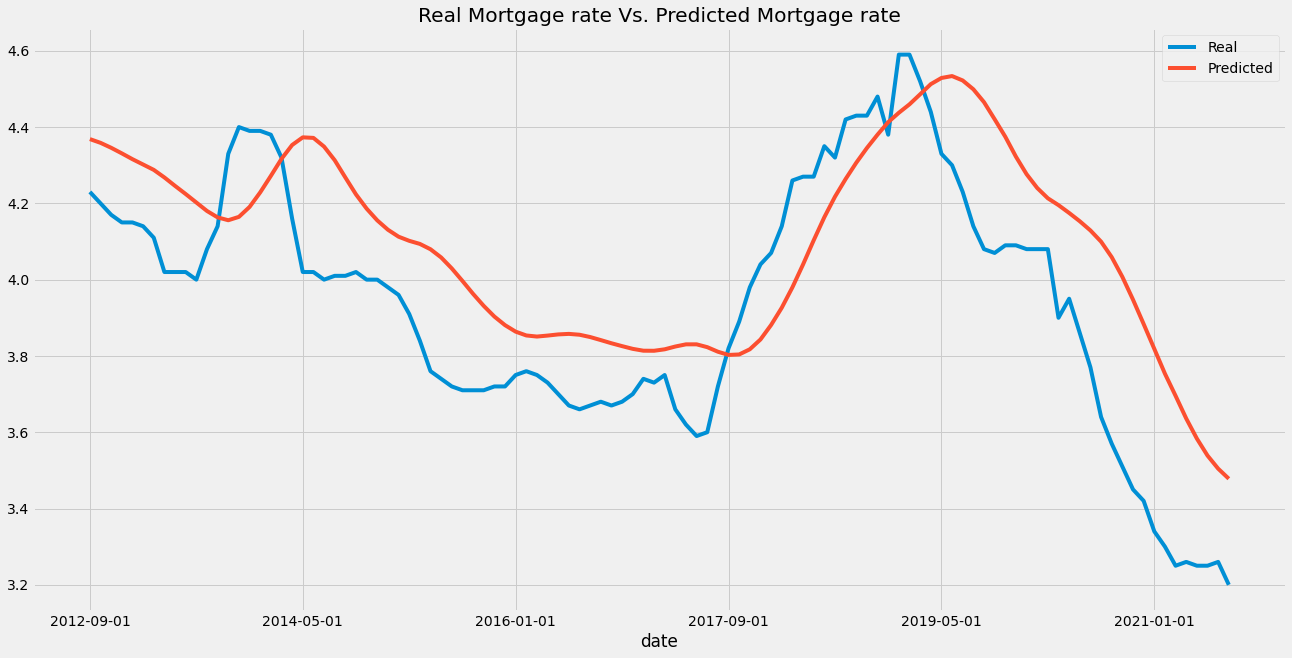

In [262]:
mortgage.plot(figsize=(20, 10), title="Real Mortgage rate Vs. Predicted Mortgage rate")

In [263]:
#def plot_multi_step(history, prediction1):
    
#    plt.figure(figsize=(15, 6))
    
#    range_history = len(history)
#    range_future = list(range(range_history, range_history +
#                        len(prediction1)))
#    plt.plot(np.arange(range_history), np.array(history), 
#             label='History')
#    plt.plot(range_future, np.array(prediction1),
#             label='Forecasted for GRU')
#    plt.plot(range_future, np.array(prediction2),
#             label='Forecasted for BiLSTM')
      
#    plt.legend(loc='upper right')
#    plt.xlabel('Time step (day)')
 #   plt.ylabel('Water demand (lit/day)')
        
#plot_multi_step(new_data, prediction_gru)

In [264]:
from keras.models import load_model

regressorGRU.save('GRU_model.h5')

In [265]:
model_gu = load_model('GRU_model.h5')

In [266]:
future_predictions = model_gu.predict(X, verbose=0)

In [267]:
future_df = pd.DataFrame(future_predictions)
future_index = pd.date_range(start='2021-09-01', periods=358, freq='MS')
future_index

DatetimeIndex(['2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01',
               ...
               '2050-09-01', '2050-10-01', '2050-11-01', '2050-12-01',
               '2051-01-01', '2051-02-01', '2051-03-01', '2051-04-01',
               '2051-05-01', '2051-06-01'],
              dtype='datetime64[ns]', length=358, freq='MS')

In [268]:
future_df['date'] = future_index
future_df.set_index('date', inplace=True)

In [269]:
future_df_5 = future_df.loc[:'2026-08-01']

<AxesSubplot:title={'center':'Predicted'}, xlabel='date'>

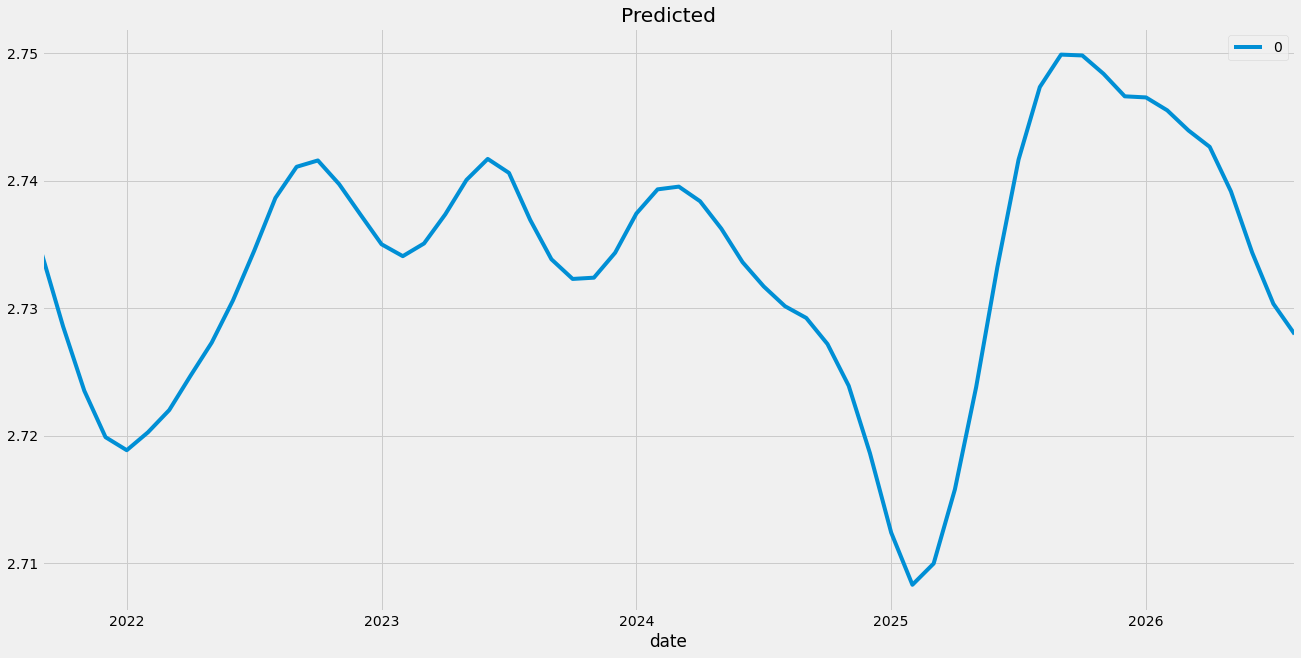

In [270]:
future_df_5.plot(figsize=(20, 10), title='Predicted')

In [ ]:
predicted = regressorGRU.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
def plot_predictions1(model, X, y, start=0, end=100)

In [ ]:
regressorGRU2 = Sequential()

regressorGRU2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU2.add(Dropout(0.2))

regressorGRU2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU2.add(Dropout(0.2))

regressorGRU2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU2.add(Dropout(0.2))

regressorGR2.add(GRU(units=50, activation='tanh'))
regressorGRU2.add(Dropout(0.2))

regressorGRU2.add(Dense(units=1))



In [ ]:
regressorGRU2.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [ ]:
regressorGRU2.fit(X_train,y_train, epochs=50, batch_size=150)

## Multivariate

In [ ]:
prediction = model.predict(train_X[-n_days_for_prediction:])